In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -----------------------------
# Data
# -----------------------------

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)

In [3]:
# -----------------------------
# MobileNet building blocks
# -----------------------------

def conv_bn_relu(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [4]:
def depthwise_separable_block(x, pw_filters, strides=1):
    """
    MobileNet core: DepthwiseConv2D (3x3, s=strides) + BN + ReLU,
    then Pointwise Conv2D (1x1) + BN + ReLU.
    """
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(pw_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [5]:
# -----------------------------
# Model (single MobileNet block)
# -----------------------------

def build_mobilenet_one_block(alpha=1.0):
    """
    Minimal MobileNet-like classifier for CIFAR-10.
    alpha: width multiplier to thin the network channels (MobileNet paper idea).
    """
    inputs = layers.Input(shape=(32, 32, 3))

    # Initial 3x3 conv (stride 1 for CIFAR-10); BN+ReLU
    c1 = int(32 * alpha)
    x = conv_bn_relu(inputs, c1, kernel_size=3, strides=1)

    # One depthwise-separable block
    c2 = int(64 * alpha)
    x = depthwise_separable_block(x, pw_filters=c2, strides=1)

    # Optional slight downsample to aggregate
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=f"mobilenet_one_block_alpha_{alpha}")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:

# -----------------------------
# Training + Visualizations
# -----------------------------

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()


In [7]:
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()

In [8]:
def show_sample_predictions(x, y_true, y_pred, class_names, n=12):
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2*cols, 2.2*rows))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[idx])
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle('Random Test Samples: True vs Predicted', y=1.02)
    plt.tight_layout(); plt.show()

In [9]:
def summarize_params(model):
    total = model.count_params()
    dw_params = sum(l.count_params() for l in model.layers if isinstance(l, layers.DepthwiseConv2D))
    pw_params = sum(l.count_params() for l in model.layers if isinstance(l, layers.Conv2D) and l.kernel_size == (1,1))
    conv3_params = sum(l.count_params() for l in model.layers if isinstance(l, layers.Conv2D) and l.kernel_size == (3,3))
    print("\nParameter Breakdown:")
    print(f"Total params: {total:,}")
    print(f"Depthwise 3x3 params: {dw_params:,}")
    print(f"Pointwise 1x1 params: {pw_params:,}")
    print(f"Standard 3x3 conv params: {conv3_params:,}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Model: "mobilenet_one_block_alpha_1.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 32, 32, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,362 (17.04 KB)

 Trainable params: 4,106 (16.04 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2833 - loss: 2.0255 - val_accuracy: 0.1003 - val_loss: 2.6181
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4252 - loss: 1.6173 - val_accuracy: 0.3401 - val_loss: 1.7650
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4718 - loss: 1.4970 - val_accuracy: 0.4161 - val_loss: 1.6206
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4926 - loss: 1.4464 - val_accuracy: 0.4420 - val_loss: 1.5344
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5068 - loss: 1.3959 - val_accuracy: 0.3860 - val_loss: 1.7445


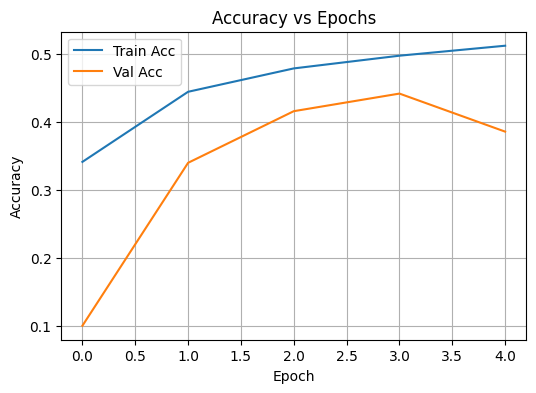

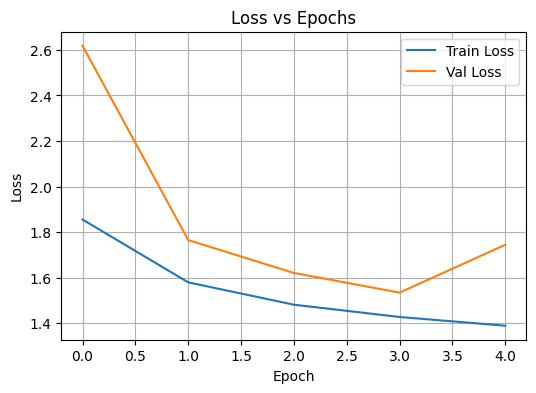


Test Accuracy: 0.3926

Classification Report:

              precision    recall  f1-score   support

    airplane       0.46      0.46      0.46      1000
  automobile       0.54      0.47      0.50      1000
        bird       0.31      0.32      0.32      1000
         cat       0.23      0.37      0.28      1000
        deer       0.55      0.21      0.30      1000
         dog       0.34      0.68      0.45      1000
        frog       0.50      0.72      0.59      1000
       horse       0.36      0.47      0.41      1000
        ship       0.84      0.15      0.25      1000
       truck       0.74      0.08      0.14      1000

    accuracy                           0.39     10000
   macro avg       0.48      0.39      0.37     10000
weighted avg       0.48      0.39      0.37     10000



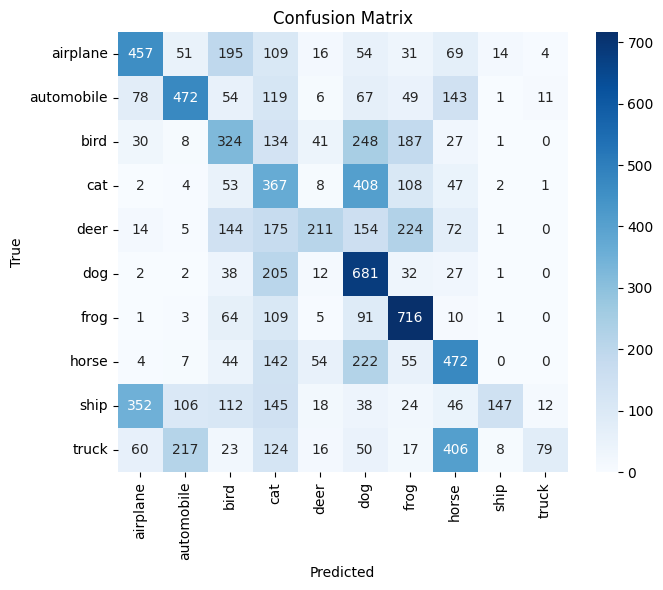

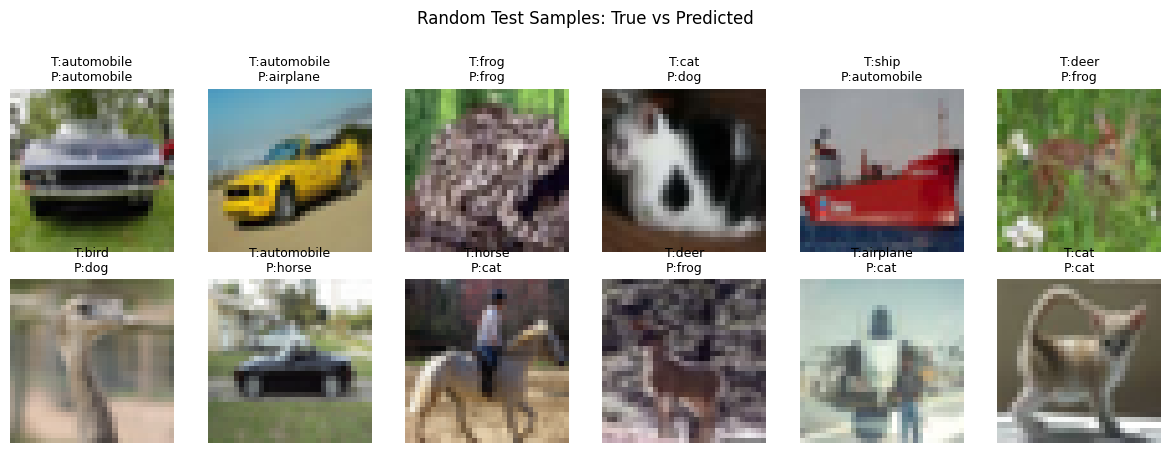


Parameter Breakdown:
Total params: 4,362
Depthwise 3x3 params: 288
Pointwise 1x1 params: 2,048
Standard 3x3 conv params: 864


In [10]:

# -----------------------------
# Run end-to-end
# -----------------------------

CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

if __name__ == "__main__":
    (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat) = load_data()

    model = build_mobilenet_one_block(alpha=1.0)
    model.summary()

    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.2,
        epochs=5,
        batch_size=128,
        verbose=1
    )

    plot_history(history)

    # Evaluate & predictions
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    y_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test.flatten()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    plot_confusion(y_true, y_pred, CLASS_NAMES)
    show_sample_predictions(x_test, y_true, y_pred, CLASS_NAMES, n=12)
    summarize_params(model)
